In [1]:
import torch
from torchvision import datasets, models, transforms

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
import zipfile
zip = zipfile.ZipFile('datasets/flowers_.zip')
zip.extractall('datasets')

In [10]:
data_dir = 'datasets/flowers'

In [11]:
image_datasets = {}

In [13]:
image_datasets['train'] = datasets.ImageFolder(data_dir + '/train', train_transform)

In [14]:
image_datasets['test'] = datasets.ImageFolder(data_dir + '/test', test_transform)

In [15]:
print("Training data size - %d" % len(image_datasets['train']))
print("Test data size - %d" % len(image_datasets['test']))

Training data size - 2569
Test data size - 550


In [16]:
class_names = image_datasets['train'].classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [17]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 550
     Root Location: datasets/flowers/test
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'train': Dataset ImageFolder
     Number of datapoints: 2569
     Root Location: datasets/flowers/train
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.

In [18]:
dataloaders = {}

In [20]:
dataloaders['train'] = torch.utils.data.DataLoader(
    image_datasets['train'],
    batch_size=8,
    shuffle=True,
    num_workers=4
)

In [21]:
dataloaders['test'] = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=8,
    shuffle=True,
    num_workers=4
)

In [22]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x1f78c0e85c0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x1f78c0e8400>}

In [23]:
inputs, labels = next(iter(dataloaders['train']))

In [24]:
inputs.shape

torch.Size([8, 3, 224, 224])

In [25]:
labels

tensor([2, 2, 1, 4, 1, 3, 2, 0])

In [26]:
import torchvision

inp = torchvision.utils.make_grid(inputs)

In [27]:
inp.shape

torch.Size([3, 228, 1810])

In [28]:
inp.max()

tensor(2.4657)

In [29]:
import numpy as np

np.clip(inp, 0, 1).max()

tensor(1.)

In [31]:
inp.numpy().transpose((1,2,0)).shape

(228, 1810, 3)

In [32]:
import matplotlib.pyplot as plt

plt.ion()

In [35]:
def img_show(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

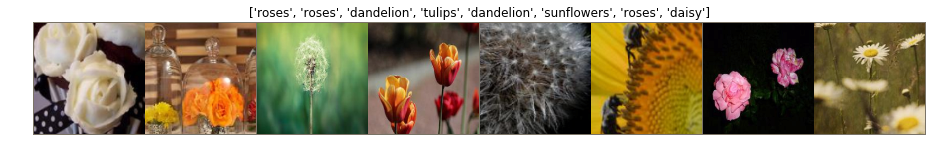

In [36]:
img_show(inp, title=[class_names[x] for x in labels])

In [37]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\isuru/.torch\models\resnet18-5c106cde.pth
100.0%


In [38]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [39]:
import torch.nn as nn

In [40]:
model.fc = nn.Linear(num_ftrs, 5)

In [41]:
criterion = nn.CrossEntropyLoss()

In [42]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [43]:
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.01)

In [45]:
def calculate_accuracy(phase, running_loss, running_corrects):
    
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return (epoch_loss, epoch_acc)

In [46]:
def phase_train(model, criterion, optimizer, scheduler):
    
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['train']:
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    calculate_accuracy('train', running_loss, running_corrects)

In [47]:
import copy

In [48]:
best_acc = 0.0

In [49]:
def phase_test(model, criterion, optimizer):
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc
    
    for inputs, labels in dataloaders['test']:
        
        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_los, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_model_wts

In [50]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
        
    print('Best test Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [51]:
model = build_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.7715 Acc: 0.7100
test Loss: 0.3715 Acc: 0.8691

Best test Acc: 0.869091


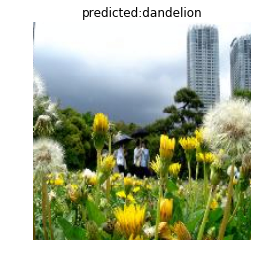

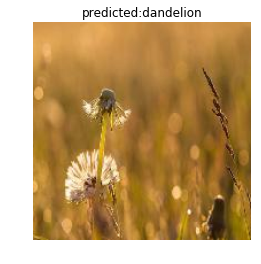

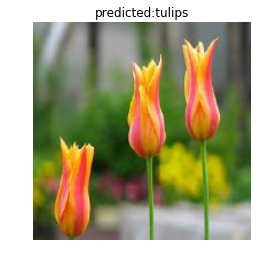

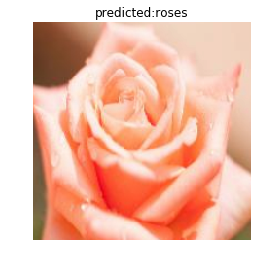

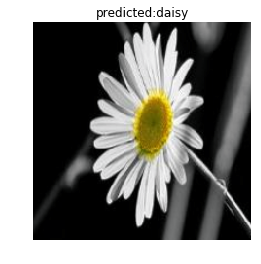

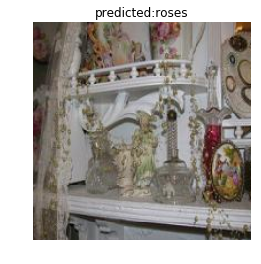

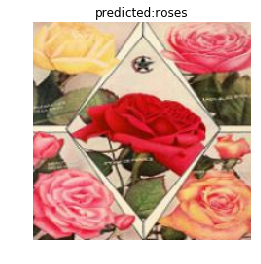

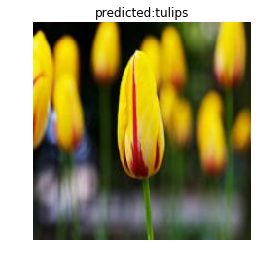

In [52]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted:' + class_names[preds[j]])